# **Decode COVID19 with Genome Analysis**

**Problem Statement :**
You are one of the researchers responding to the White House Office of Science and Technology Policy center’s call to conduct advanced research on Covid-19. You are working with CDC,  which has led a coordinated effort to set up a machine readable dataset.

**About Dataset :**
Dataset represents the most extensive machine-readable coronavirus literature collection available for data and text mining to date, with over 29,000 articles, more than 13,000 of which have full text.

Using the **CORD-NER dataset** and Knowledge Graph, determine and map out the details of the SARS-CoV-2 genome to assist understanding of the emergence, evolution and diagnosis of this deadly virus.



In [53]:
!pip install rdflib


In [54]:
# !pip uninstall importlib


In [55]:
# !pip install importlib

In [56]:
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import warnings
import pprint
import tensorflow as tf
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud

In [58]:

import pandas as pd 
import numpy as np
from tqdm import tqdm 
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE


pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

# 1.  Dataset & preprocessing

In [59]:
jso_da = pd.read_json('/kaggle/input/jsonfull/CORD-NER-full.json',nrows=10000, lines=True)


In [60]:
jso_da.to_csv('CORD_NER-Full.csv')

In [61]:
dt = pd.read_csv('/kaggle/working/CORD_NER-Full.csv')
dt.head(10)

,Unnamed: 0,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities
0,0,0,CZI,10.1007/s00134-020-05985-9,NaN,32125455.0,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,Angiotensin-converting enzyme 2 (ACE2) as a SA...,NaN,SARS-CoV-2 has been sequenced [3] . A phylogen...,"[{'text': 'Angiotensin-converting enzyme 2', '..."
1,1,1,CZI,10.1038/s41421-020-0147-1,NaN,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,Comparative genetic analysis of the novel coro...,NaN,Comparative genetic analysis of the novel coro...,"[{'text': 'genetic analysis', 'start': 12, 'en..."
2,2,2,CZI,10.3390/jcm9020538,NaN,NaN,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ..."
3,3,3,CZI,10.3390/jcm9020575,NaN,32093211.0,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':..."
4,4,4,CZI,10.1007/s00134-020-05976-w,NaN,32125453.0,2020,"Zhang, Wei",Intensive Care Med,Imaging changes in severe COVID-19 pneumonia,NaN,NaN,"[{'text': 'COVID-19', 'start': 26, 'end': 34, ..."
5,5,5,CZI,10.1016/j.idm.2020.02.001,NaN,NaN,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7..."
6,6,6,CZI,10.1016/j.idm.2020.02.002,NaN,NaN,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,..."
7,7,7,CZI,10.1016/s2214-109x(20)30065-6,NaN,32105614.0,2020,"Zeng, Yingchun; Zhen, Yan",The Lancet. Global health,RETRACTED: Chinese medical staff request inter...,NaN,NaN,"[{'text': 'Chinese', 'start': 11, 'end': 18, '..."
8,8,8,CZI,10.1093/jtm/taaa030,NaN,NaN,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,Conclusions: The cruise ship conditions clearl...,"[{'text': 'COVID-19', 'start': 0, 'end': 8, 't..."
9,9,9,CZI,10.1128/mBio.02764-19,NaN,NaN,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,Distinct Roles for Sialoside and Protein Recep...,Coronaviruses (CoVs) are common human and anim...,could be attributed to S proteins. Intriguingl...,"[{'text': 'Sialoside', 'start': 19, 'end': 28,..."


In [62]:
ent= dt["entities"][0]

In [63]:
ent

"[{'text': 'Angiotensin-converting enzyme 2', 'start': 0, 'end': 31, 'type': 'GENE_OR_GENOME'}, {'text': 'ACE2', 'start': 33, 'end': 37, 'type': 'GENE_OR_GENOME'}, {'text': 'SARS-CoV-2', 'start': 44, 'end': 54, 'type': 'CORONAVIRUS'}, {'text': 'receptor', 'start': 55, 'end': 63, 'type': 'CHEMICAL'}, {'text': 'SARS-CoV-2', 'start': 120, 'end': 130, 'type': 'CORONAVIRUS'}, {'text': 'phylogenetic', 'start': 158, 'end': 170, 'type': 'EVOLUTION'}, {'text': 'bat', 'start': 195, 'end': 198, 'type': 'WILDLIFE'}, {'text': 'SARS-CoV-2', 'start': 214, 'end': 224, 'type': 'CORONAVIRUS'}, {'text': 'intermediate hosts', 'start': 259, 'end': 277, 'type': 'NORP'}, {'text': 'SARS-CoV-2', 'start': 282, 'end': 292, 'type': 'CORONAVIRUS'}, {'text': 'pangolins', 'start': 304, 'end': 313, 'type': 'WILDLIFE'}, {'text': 'mice', 'start': 323, 'end': 327, 'type': 'ORGANISM'}, {'text': 'rats', 'start': 332, 'end': 336, 'type': 'EUKARYOTE'}, {'text': 'SARS-CoV-2', 'start': 374, 'end': 384, 'type': 'CORONAVIRUS'},

let's find the number of articles published in 2020

In [64]:

dt = dt[dt.publish_time=='2020']
print(f'There were {len(dt)} articles published in 2020')

There were 1148 articles published in 2020


Since articles without abstract do not make any sense let's remove them

In [65]:
lent = len(dt)
dt.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {lent-len(dt)} articles with missing abstract')

Dropped 370 articles with missing abstract


let's remove the duplicate abstract articles

In [66]:
lent = len(dt)
dt.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {lent-len(dt)} articles with duplicate abstract')

Dropped 6 articles with duplicate abstract


Warning: Although the articles with duplicated abstracts are dropped, there still exist some articles with meaningless abstracts. The cleaning strategy here only weakens the effects of those meaningless abstracts.

In [67]:
dt['abstract'] = dt['abstract'].apply(lambda x: x.strip().lower())
stopwords = set(stopwords.words('english'))
dt['abstract_tokens'] = dt['abstract'].apply(lambda x: word_tokenize(x))


dt['abstract_tokens'] = dt['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()]) #only english words will be left

dt['abstract_tokens'] = dt['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])#stopword removal


dt['abstract_tokens'] = dt['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])#single chracter removal

dt.head()

,Unnamed: 0,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities,abstract_tokens
2,2,2,CZI,10.3390/jcm9020538,NaN,NaN,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ...","[geographic, spread, novel, coronavirus, infec..."
3,3,3,CZI,10.3390/jcm9020575,NaN,32093211.0,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':...","[december, cases, unidentified, pneumonia, his..."
5,5,5,CZI,10.1016/j.idm.2020.02.001,NaN,NaN,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7...","[basic, reproduction, number, infectious, agen..."
6,6,6,CZI,10.1016/j.idm.2020.02.002,NaN,NaN,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,...","[initial, cluster, severe, pneumonia, cases, t..."
8,8,8,CZI,10.1093/jtm/taaa030,NaN,NaN,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,Conclusions: The cruise ship conditions clearl...,"[{'text': 'COVID-19', 'start': 0, 'end': 8, 't...","[cruise, ships, carry, large, number, people, ..."


In [68]:
dt.reset_index(drop=True,inplace=True)


This code snippet resets the index of a DataFrame in pandas, dropping the existing index and assigning a new sequential index. The drop=True parameter ensures that the old index is removed, and inplace=True modifies the DataFrame in place without the need for reassignment.



In [69]:
inv_i = {}
for i,se in enumerate(list(dt['abstract_tokens'])):
    for token in set(se):
        if token not in inv_i:
            inv_i[token] = [i]
        else:
            inv_i[token].append(i)

print(f'There are {len(inv_i)} unique words in inverted index')

There are 8711 unique words in inverted index



This code creates an inverted index (inv_i) for tokens in a DataFrame column ('abstract_tokens') by mapping each unique token to a list of document indices where it appears. The final line prints the count of unique words in the inverted index.

In [70]:
print(inv_i["sars"])

[1, 8, 11, 12, 16, 19, 24, 28, 33, 37, 47, 49, 58, 60, 61, 63, 67, 69, 72, 74, 84, 94, 101, 121, 126, 128, 129, 135, 136, 141, 147, 149, 157, 159, 160, 162, 166, 178, 200, 202, 218, 224, 230, 231, 233, 236, 247, 251, 253, 257, 264, 284, 311, 321, 325, 332, 336, 338, 341, 353, 376, 380, 384, 392, 396, 407, 425, 444, 452, 453, 464, 481, 484, 489, 495, 508, 522, 538, 546, 560, 561, 563, 571, 591, 598, 600, 602, 604, 661, 662, 689, 714, 718, 723, 735, 737, 754, 756, 765, 768]


# 2.Article Matching and Deep Cleaning

In [71]:
keyc = ["sars-cov-2","sars","cov-2","2019-ncov","ncov","cov","covid19","covid","corona",
             "coronavirus"]
cov_i = []
for word in keyc:
    try:
        cov_i += inv_i[word]
    except:
        pass
cov_i = list(set(cov_i))
print(f'Found {len(cov_i)} articles related to covid19')

Found 606 articles related to covid19


This code searches for document indices related to COVID-19 by iterating through a list of keywords. It accumulates these indices in the cov_i list, ensuring uniqueness, and then prints the count of articles related to COVID-19 found in the inverted index.

In [72]:
cov_ar = dt.iloc[cov_i,:]
cov_ar.head()

,Unnamed: 0,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities,abstract_tokens
0,2,2,CZI,10.3390/jcm9020538,NaN,NaN,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ...","[geographic, spread, novel, coronavirus, infec..."
1,3,3,CZI,10.3390/jcm9020575,NaN,32093211.0,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':...","[december, cases, unidentified, pneumonia, his..."
2,5,5,CZI,10.1016/j.idm.2020.02.001,NaN,NaN,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7...","[basic, reproduction, number, infectious, agen..."
3,6,6,CZI,10.1016/j.idm.2020.02.002,NaN,NaN,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,...","[initial, cluster, severe, pneumonia, cases, t..."
5,9,9,CZI,10.1128/mBio.02764-19,NaN,NaN,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,Distinct Roles for Sialoside and Protein Recep...,coronaviruses (covs) are common human and anim...,could be attributed to S proteins. Intriguingl...,"[{'text': 'Sialoside', 'start': 19, 'end': 28,...","[coronaviruses, covs, common, human, animal, p..."



This code selects rows from a DataFrame dt based on the indices in the list cov_i and assigns the resulting subset to the variable cov_ar. The head() function then displays the first few rows of this subset

For topic modeling and visualization, lemmatization is needed. POS tagging technique is also used to filter meaningful words.

In [73]:
def lemmat(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_o = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        
        texts_o.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_o  


This function performs lemmatization on a list of tokenized texts using spaCy. It returns a new list (texts_o) where each word is lemmatized, excluding pronouns, and filtered based on specified allowed part-of-speech tags (default: NOUN, ADJ, VERB, ADV).

First, let's see how the word cloud of this corpus looks like.

Text(0.5, 1.0, 'Word Cloud: Articles Related to SAR-Cov-2')

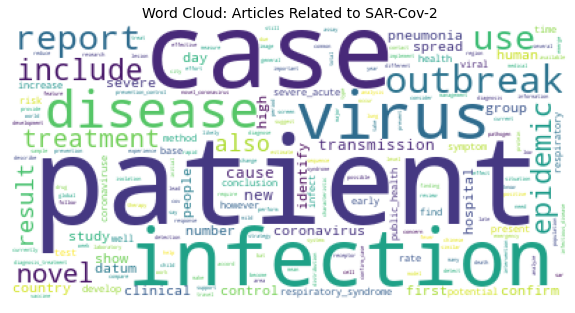

In [74]:
cov_ar['Lemma_Tokens'] = lemmat(list(cov_ar['abstract_tokens']))
big = Phrases(list(cov_ar['Lemma_Tokens']), min_count=3)
cov_ar['Phrase_Lemma_Tokens'] = cov_ar['Lemma_Tokens'].apply(lambda x: big[x])


cov_absokens = []
for tokens in list(cov_ar['Phrase_Lemma_Tokens']):
    cov_absokens += tokens
cov_wordcnt_dict = collections.Counter(cov_absokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(cov_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to SAR-Cov-2' ,fontsize=14)

This code generates a word cloud visualization from the lemmatized and phrased tokens extracted from the 'abstract_tokens' column in the DataFrame cov_ar. It utilizes the wordcloud library to create a visual representation of word frequencies in the text, enhancing the appearance and readability of the cloud.
Words  like  'patient', 'infection', 'disease', 'outbreak', 'virus', 'case, 'epidemic' occur frequently in this corpus.

# 3.Topic Extraction : LDA

100%|██████████| 8/8 [00:31<00:00,  3.96s/it]

Topic number selection took 31.719011783599854 seconds


Perplexity:  7.7679284960680635


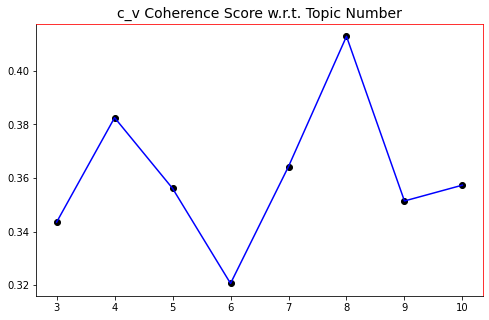

In [75]:
id2article = corpora.Dictionary(list(cov_ar['Phrase_Lemma_Tokens']))
corpusarticle = [id2article.doc2bow(tokens) 
                        for tokens in list(cov_ar['Phrase_Lemma_Tokens'])]
begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpusarticle,
                            id2word=id2article,
                            num_topics=nb_topics, 
                            random_state=8,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)
 
    cm = CoherenceModel(model=lda_model, 
                        texts=list(cov_ar['Phrase_Lemma_Tokens']),
                        dictionary=id2article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='blue')
ax.scatter(range(3,11),coherence_scores,marker='o',color='black')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)

for pos in ['top', 'right']:
    ax.spines[pos].set_color('red')
lda_mod = LdaMulticore(corpus=corpusarticle,
                        id2word=id2article,
                        num_topics=8, 
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        iterations=100,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', abs(lda_mod.log_perplexity(corpusarticle)))



This code performs topic modeling using Latent Dirichlet Allocation (LDA) on a corpus of lemmatized and phrased tokens (Phrase_Lemma_Tokens) from the DataFrame cov_ar. It evaluates coherence scores for different numbers of topics and plots the results, with the axes colored blue and black, and the top and right spines in red

The higher the c_v coherence score is, the more suitable the topic number should be. Hence, I choose 8 as the topic number for analysis.

This code initializes an LDA (Latent Dirichlet Allocation) model using the specified parameters and corpus (corpusarticle). It then prints the perplexity score, a measure of how well the model predicts the given corpus, with lower values indicating better performance.

# Word per Topic

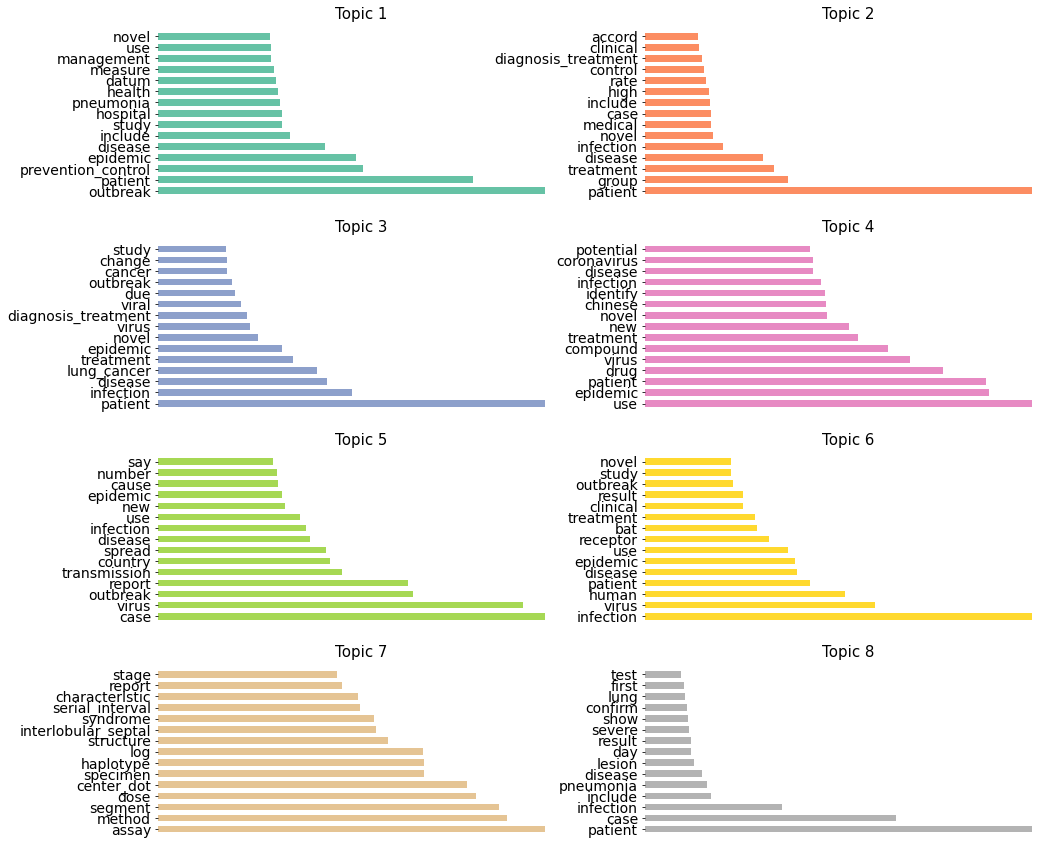

In [76]:
word_topic_scores = lda_mod.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
 
    ax = fig.add_subplot(4,2,i+1)
    ax.barh(y=words, width=probs, height=0.6, color=sns.color_palette("Set2")[i])

    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

The initial topic delves into hospital practices aimed at safeguarding public health through the adoption of treatment strategies and infection prevention control measures, featuring terms such as 'infection,' 'hospital,' 'disease,' 'prevention control,' 'public health,' and 'treatment strategies.'

The second topic likely discusses the evolution of the virus within the human host, touching upon concepts like 'virus,' 'human,' 'cell,' 'host,' 'protein,' and 'infection.'

The third topic revolves around scientists conducting tests on western drugs in a laboratory setting for atypical pneumonia and myocardial conditions, involving terms like 'scientist,' 'lab,' 'test,' 'ventilator,' 'drug,' 'western,' 'atypical pneumonia,' and 'myocardial.'

The fourth topic potentially explores patient cases originating from the distribution of lesions in the lungs, focusing on terms like 'patient,' 'case,' 'lesion,' 'infection,' 'lung,' and 'distribution.'

The fifth topic examines observations on hospitalized COVID-19 confirmed patients regarding syndrome, treatment, effects, and precautions in isolation, featuring terms such as 'patient,' 'treatment,' 'syndrome,' 'confirm,' 'hospitalize observation,' 'effect,' and 'precaution.'

The sixth topic discusses the surge in COVID-19 cases within the country, highlighting terms like 'country,' 'case,' 'transmission,' 'outbreak,' 'report,' and 'virus.'

The seventh topic likely explores symptoms of COVID-19 in patients, focusing on terms like 'patient,' 'case,' 'fever,' and 'high.'

The eighth topic potentially delves into the psychological impact and vaccine research by scientists in the medical field, along with considerations of COVID-19 cases in wild animals, incorporating terms like 'vaccine,' 'scientist,' 'research,' 'medical,' 'journal,' and 'wild animal.'







# 4. LDA Visualization

In [77]:
from pyLDAvis import gensim

In [78]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_mod, corpusarticle, id2article)

CPU times: user 511 ms, sys: 12.3 ms, total: 524 ms
Wall time: 706 ms


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.076694 -0.123920       1        1  34.158916
7     -0.142490 -0.051610       2        1  21.946983
5      0.036087 -0.074778       3        1  13.893002
1     -0.150482  0.022836       4        1  10.556529
0      0.015266  0.003899       5        1   7.315899
3      0.096194  0.014450       6        1   6.480501
2      0.040659  0.076667       7        1   3.887183
6      0.028071  0.132455       8        1   1.760987, topic_info=           Term        Freq       Total Category  logprob  loglift
239     patient  870.000000  870.000000  Default  30.0000  30.0000
61         case  656.000000  656.000000  Default  29.0000  29.0000
169    outbreak  300.000000  300.000000  Default  28.0000  28.0000
23    infection  486.000000  486.000000  Default  27.0000  27.0000
12     epidemic  215.000000  215.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1166   hospital    2.310367  107.480241   Topic8  -5.9117   0.1994
530     protein    2.242533   75.068410   Topic8  -5.9415   0.5285
99    pneumonia    2.294953  151.846482   Topic8  -5.9184  -0.1529
34        novel    2.275408  205.181322   Topic8  -5.9269  -0.4624
50        study    2.182583  147.833601   Topic8  -5.9686  -0.1763

[607 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2333      2  0.918370      abnormal
2333      4  0.045919      abnormal
2333      6  0.045919      abnormal
1885      2  0.910876   abnormality
572       1  0.450027        access
...     ...       ...           ...
1826      2  0.026807     worldwide
1826      7  0.080420     worldwide
3608      5  0.628136         wound
5181      8  0.494730     xuebijing
344       3  0.849679  zoonotic_cov

[1458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 6, 2, 1, 4, 3, 7])

As we can see from the interactive figure above, topic 1 and 2  are very close as well as 7 and 8 (5 is also similar to 7). The other topics are separated appropriately.


# Topic per document

In [79]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpusarticle)):
    document_topic = lda_model.get_document_topics(corpusarticle[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

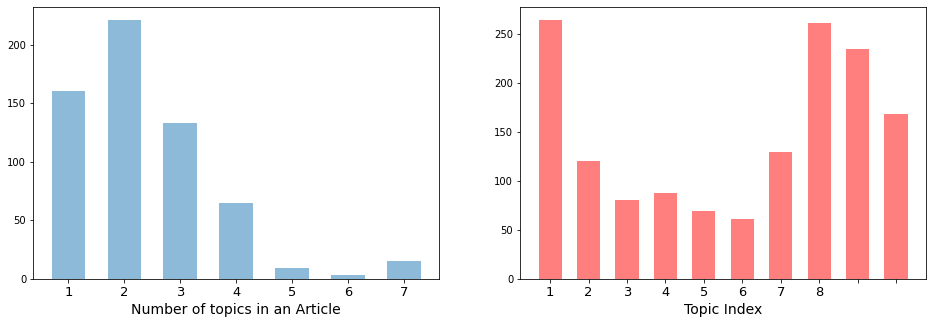

In [80]:

num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color('black')
    ax.set_xticklabels(['1','2','3','4','5','6','7','8'],fontsize=13)

1.The left figure shows that there are very few articles who covered all the topics. 3rd and 4th topic are mostly present in many articles..

2.The right figure shows that occurence frequencies of topics are not very close as we can see many articles covered 1st and 6th topic.
